In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from statistics import mean
import os
from sklearn.metrics.pairwise import euclidean_distances
import math

In [2]:
def read_barcodes(barcodes_file):
    barcodes = pd.read_csv(barcodes_file, sep = '\t',header = None)
    barcodes.columns = ['barcode']
    barcodes.index += 1
    barcodes['barcode_id'] = barcodes.index
    return barcodes

def read_features(features_file):
    features = pd.read_csv(features_file, sep = '\t',header = None)
    features.index += 1
    features.columns = ['feature_code','value','type']
    features['feature_id'] = features.index
    features['feature_id'] = pd.to_numeric(features['feature_id'])
    return features

def read_matrix(matrix_file):
    matrix = pd.read_csv(matrix_file,sep = '\t')
    matrix = matrix.drop([0])
    matrix[['feature_id','barcode_id', 'count']] = matrix['%%MatrixMarket matrix coordinate integer general'].str.split(expand=True)
    matrix = matrix.drop(['%%MatrixMarket matrix coordinate integer general'], axis = 1)
    matrix = matrix.apply(pd.to_numeric)
    matrix['count']=matrix['count'].astype(int)
    return matrix

def merge_matrix(matrix,barcodes,features):
    matrix = pd.merge(matrix, barcodes, on="barcode_id")
    matrix = pd.merge(matrix, features, on="feature_id")
    #matrix = matrix.drop(['barcode_id','feature_id'],axis=1)
    return matrix


def get_value_matrix(matrix):
    v_t = matrix['value'].str.split('_',n=1,expand=True)
    matrix['value']=v_t[0]
    matrix['value_type']=v_t[1]
    return matrix

def get_tetramer_matrix(matrix):
    matrix = matrix.sort_values(by=['count'],ascending=False)
    tetramers = matrix.drop_duplicates('barcode')
    tetramers = tetramers[tetramers['count']>5]
    tetramers['tetramer'] = tetramers['value']
    tetramers =  tetramers[['barcode_id','tetramer']]
    matrix = pd.merge(matrix, tetramers, on="barcode_id")
    return matrix[['barcode','value','tetramer','count']]

In [3]:
def prep_annot_data(data):
    data_c = data[data['is_cell']==True].reset_index(drop=True)
    data_c = data_c[data_c['chain'] == "TRB"]
    
    data_c = data_c[-data_c['v_gene'].isna()]
    data_c = data_c[-data_c['j_gene'].isna()]
    
    data_c = data_c[-data_c['cdr3'].isna()]
    #data_no_10x = data_no_10x[-data_no_10x['antigen.epitope'].isna()]
    data_c = data_c[-data_c['v_gene'].str.contains(',')]
    data_c = data_c[-data_c['j_gene'].str.contains(',')]
    data_c = data_c[-data_c['cdr3'].str.contains('\*')]
    return data_c

def merge_anot_matrix(data_c,matrix):
    data_c = pd.merge(data_c,matrix, on='barcode')
    data_c = data_c[['cdr3','count','tetramer','value','barcode']]
    data_c = data_c[data_c['cdr3']!='None']
    return data_c

### Normalization code

In [4]:
def sum_counts(data, cell_col_name, count_col_name, cell):
    return sum(data[data[cell_col_name]==cell][count_col_name])

def norm_logp_with_total_average(data, cell_id_col, count_col):
    # total count for cell
    cell_all_counts = pd.DataFrame(data[cell_id_col].drop_duplicates())
    cell_all_counts['counts']= cell_all_counts[cell_id_col].apply(lambda x: sum_counts(data_c_all,cell_id_col,count_col,x))
    
    cell_all_counts_dict = pd.Series(cell_all_counts['counts'].values,index=cell_all_counts[cell_id_col]).to_dict()
    # average total count for cell
    average_total_count = cell_all_counts['counts'].mean()
    # normalize log(1 + count / (total count for cell) * (average total count for cell)) 
    data['count']= data.apply(lambda row : math.log(1 + row[count_col]/cell_all_counts_dict[row[cell_id_col]]*average_total_count),axis=1)
    return data
    
    
def norm_logp(data, count_col):
    data[count_col]= data[count_col].apply(lambda x : math.log1p(x))
    return data
    

### Pivot code

In [5]:
def pivot_data(data):
    data = data[['count','cdr3','tetramer']]
    data = data.pivot_table('count','cdr3','value')
    data = data.fillna(0)
    return data

## PCA code

In [6]:
def pca(data, n):
    
    if type(n) == int:
        x = StandardScaler().fit_transform(data)
        pca = PCA(n_components = n )
        principalComponents = pca.fit_transform(x)
        df_pca = pd.DataFrame(data = principalComponents)
        return df_pca, pca
        
    else:
        return data, pca

### TSNE code

In [7]:
def tsne(data,n,random_s,p):
    if type(n) == int:
        X_embedded = TSNE(n_components=n,init='pca',
                         random_state=random_s, perplexity=p).fit_transform(data)
        return X_embedded

## Reading and processing of raw data

In [114]:
barcodes = read_barcodes('data/exploring_immunity/filtered_feature_bc_matrix/barcodes.tsv')
features = read_features('data/exploring_immunity/filtered_feature_bc_matrix/features.tsv')
matrix = read_matrix('data/exploring_immunity/filtered_feature_bc_matrix/matrix.mtx')
matrix = merge_matrix(matrix,barcodes,features)
matrix = get_value_matrix(matrix)

matrix = matrix[matrix['type']=='Antibody Capture']
matrix = matrix[matrix['value_type']!='TotalSeqC']
matrix_t = get_tetramer_matrix(matrix)

In [175]:
matrix_t.head(5)

,barcode,value,tetramer,count
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL,AAKGRGAAL,76112470
1,TTTGTCATCAGGTAAA-40,QYDPVAALF,AAKGRGAAL,2
2,TTTGTCATCAGGTAAA-40,KLGGALQAK,AAKGRGAAL,1
3,TTTGTCATCAGGTAAA-40,NLVPMVATV,AAKGRGAAL,1
4,TTTGTCATCAGGTAAA-40,QPRAPIRPI,AAKGRGAAL,1


In [140]:
data = pd.read_csv("/home/yuliajk/projects/tcr_emb_2023/data/exploring_immunity/vdj_v1_hs_aggregated_donor1_all_contig_annotations.csv", sep = ',')
data_c_annot = prep_annot_data(data)
data_c = data_c_annot.copy()
data_c = merge_anot_matrix(data_c,matrix_t)
data_c['count'].mean()

375.7858468262266

In [141]:
data_c['count'].median()

2.0

In [142]:
data_c_all = data_c.copy()

In [179]:
data_c_all.to_csv('data_scripts/10x_tetramer_annot.txt', sep='\t', index = False)
matrix_t.to_csv('data_scripts/10x_tetramer_matrix.txt', sep='\t', index = False)

## Analysis

In [9]:
data_c_all = pd.read_csv('data_scripts/10x_tetramer_annot.txt', sep='\t')
data_c_all.head(5)

,cdr3,count,tetramer,value,barcode
0,CATSRDRGHGDTIYF,1.080418,KLGGALQAK,KLGGALQAK,AAACCTGAGAGTGAGA-23
1,CATSRDRGHGDTIYF,0.526589,KLGGALQAK,AVFDRKSDAK,AAACCTGAGAGTGAGA-23
2,CATSRDRGHGDTIYF,0.526589,KLGGALQAK,RLRAEAQVK,AAACCTGAGAGTGAGA-23
3,CASSLYSATGELFF,1.962020,AVFDRKSDAK,AVFDRKSDAK,AAACCTGAGATTACCC-16
4,CASSLYSATGELFF,0.959135,AVFDRKSDAK,KLGGALQAK,AAACCTGAGATTACCC-16


In [10]:
matrix_t = pd.read_csv('data_scripts/10x_tetramer_matrix.txt', sep='\t')
matrix_t.head(5)

,barcode,value,tetramer,count
0,TTTGTCATCAGGTAAA-40,AAKGRGAAL,AAKGRGAAL,76112470
1,TTTGTCATCAGGTAAA-40,QYDPVAALF,AAKGRGAAL,2
2,TTTGTCATCAGGTAAA-40,KLGGALQAK,AAKGRGAAL,1
3,TTTGTCATCAGGTAAA-40,NLVPMVATV,AAKGRGAAL,1
4,TTTGTCATCAGGTAAA-40,QPRAPIRPI,AAKGRGAAL,1


### logP normalization

Нормировка logp
Без отсечки по кайнтам

In [166]:
data_c_n = norm_logp(data_c_all, 'count')
data_c_p = pivot_data(data_c_n)

In [177]:
data_c_p.head(5)

tetramer,AAKGRGAAL,ALIAPVHAV,AVFDRKSDAK,AYAQKIFKI,AYSSAGASI,CLGGLLTMV,CLLGTYTQDV,CLLWSFQTSA,CYTWNQMNL,ELAGIGILTV,...,SLEGGGLGY,SLFNTVATL,SLFNTVATLY,SLLMWITQV,SLYNTVATLY,STEGGGLAY,TPRVTGGGAM,VTEHDTLLY,YLLEMLWRL,YLNDHLEPWI
cdr3,,,,,,,,,,,,,,,,,,,,,
CAAAGEADTQYF,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAEDPEWGAEAFF,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAEGGGPLTDTQYF,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAGGGGTEKLFF,0.0,0.0,0.768419,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAAGWGIGTEAFF,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.884842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
pca_df, pca_model = pca(data_c_p,46)
pca_df_data = pca_df.copy()
pca_df_data['cdr3']=data_c_p.index

pca_df_data=pca_df_data.merge(data_c_n[['cdr3']], how='right', on='cdr3' )
pca_df_data= pca_df_data.groupby(['cdr3']).first().reset_index()

<AxesSubplot:>

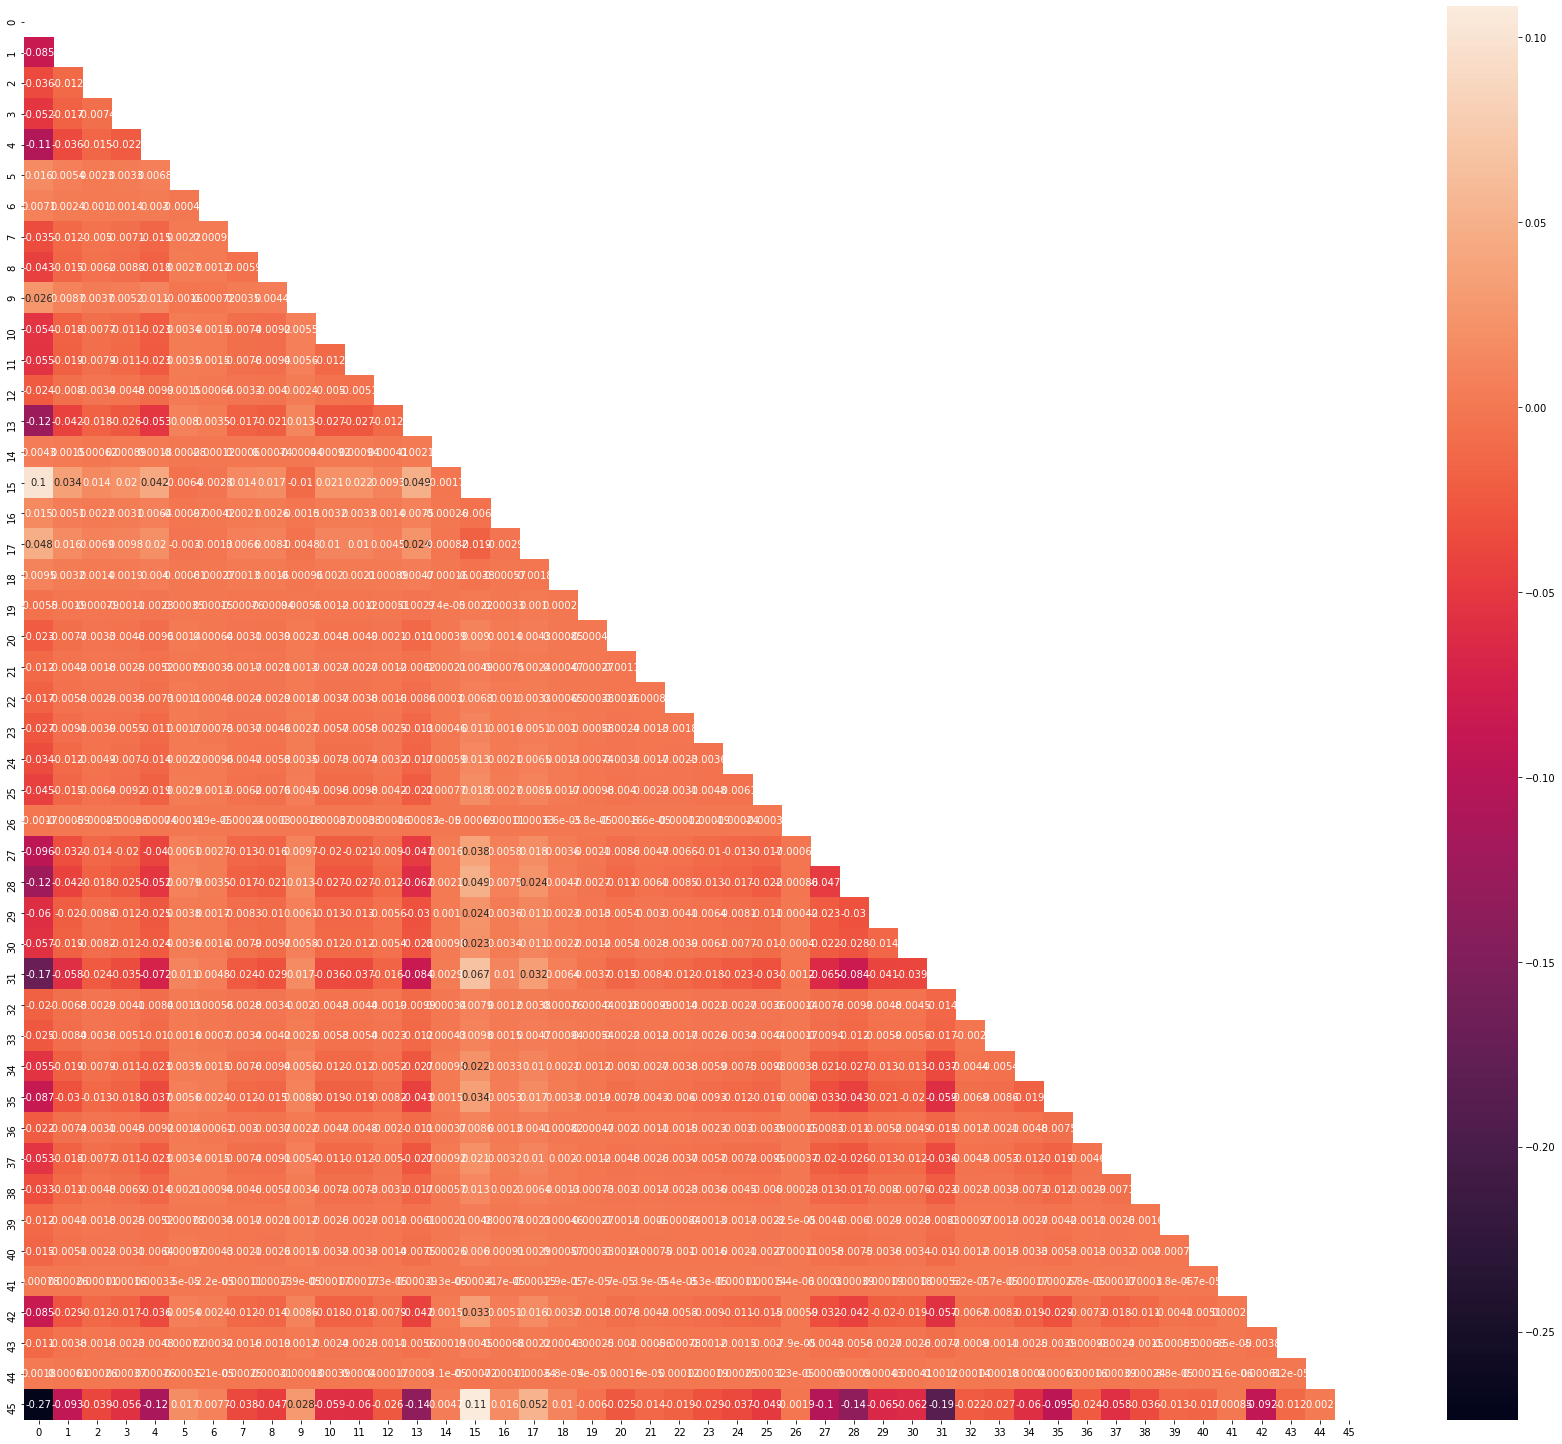

In [169]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

In [ ]:
X_embedded = tsne(pca_df,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


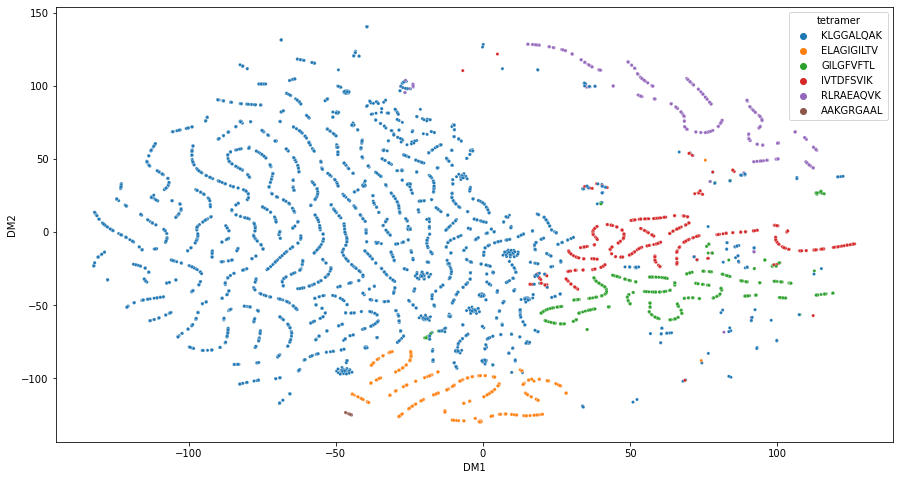

In [171]:

tsne_df_data = tsne_df.copy()
tsne_df_data['cdr3']=data_c_p.index
tsne_df_data=tsne_df_data.merge( data_c_n[['cdr3','tetramer']], how='right', on='cdr3' )
tsne_df_data= tsne_df_data.groupby(['cdr3']).first().reset_index()
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)


### Another normalization with total and avegage

In [ ]:
data_c_n = norm_logp_with_total_average(data_c_all, 'barcode','count')
data_c_p = pivot_data(data_c_n)

In [60]:
pca_df, pca_model = pca(data_c_p,50)
pca_df_data = pca_df.copy()
pca_df_data['cdr3']=data_c_p.index

pca_df_data=pca_df_data.merge(data_c_n[['cdr3']], how='right', on='cdr3' )
pca_df_data= pca_df_data.groupby(['cdr3']).first().reset_index()

<AxesSubplot:>

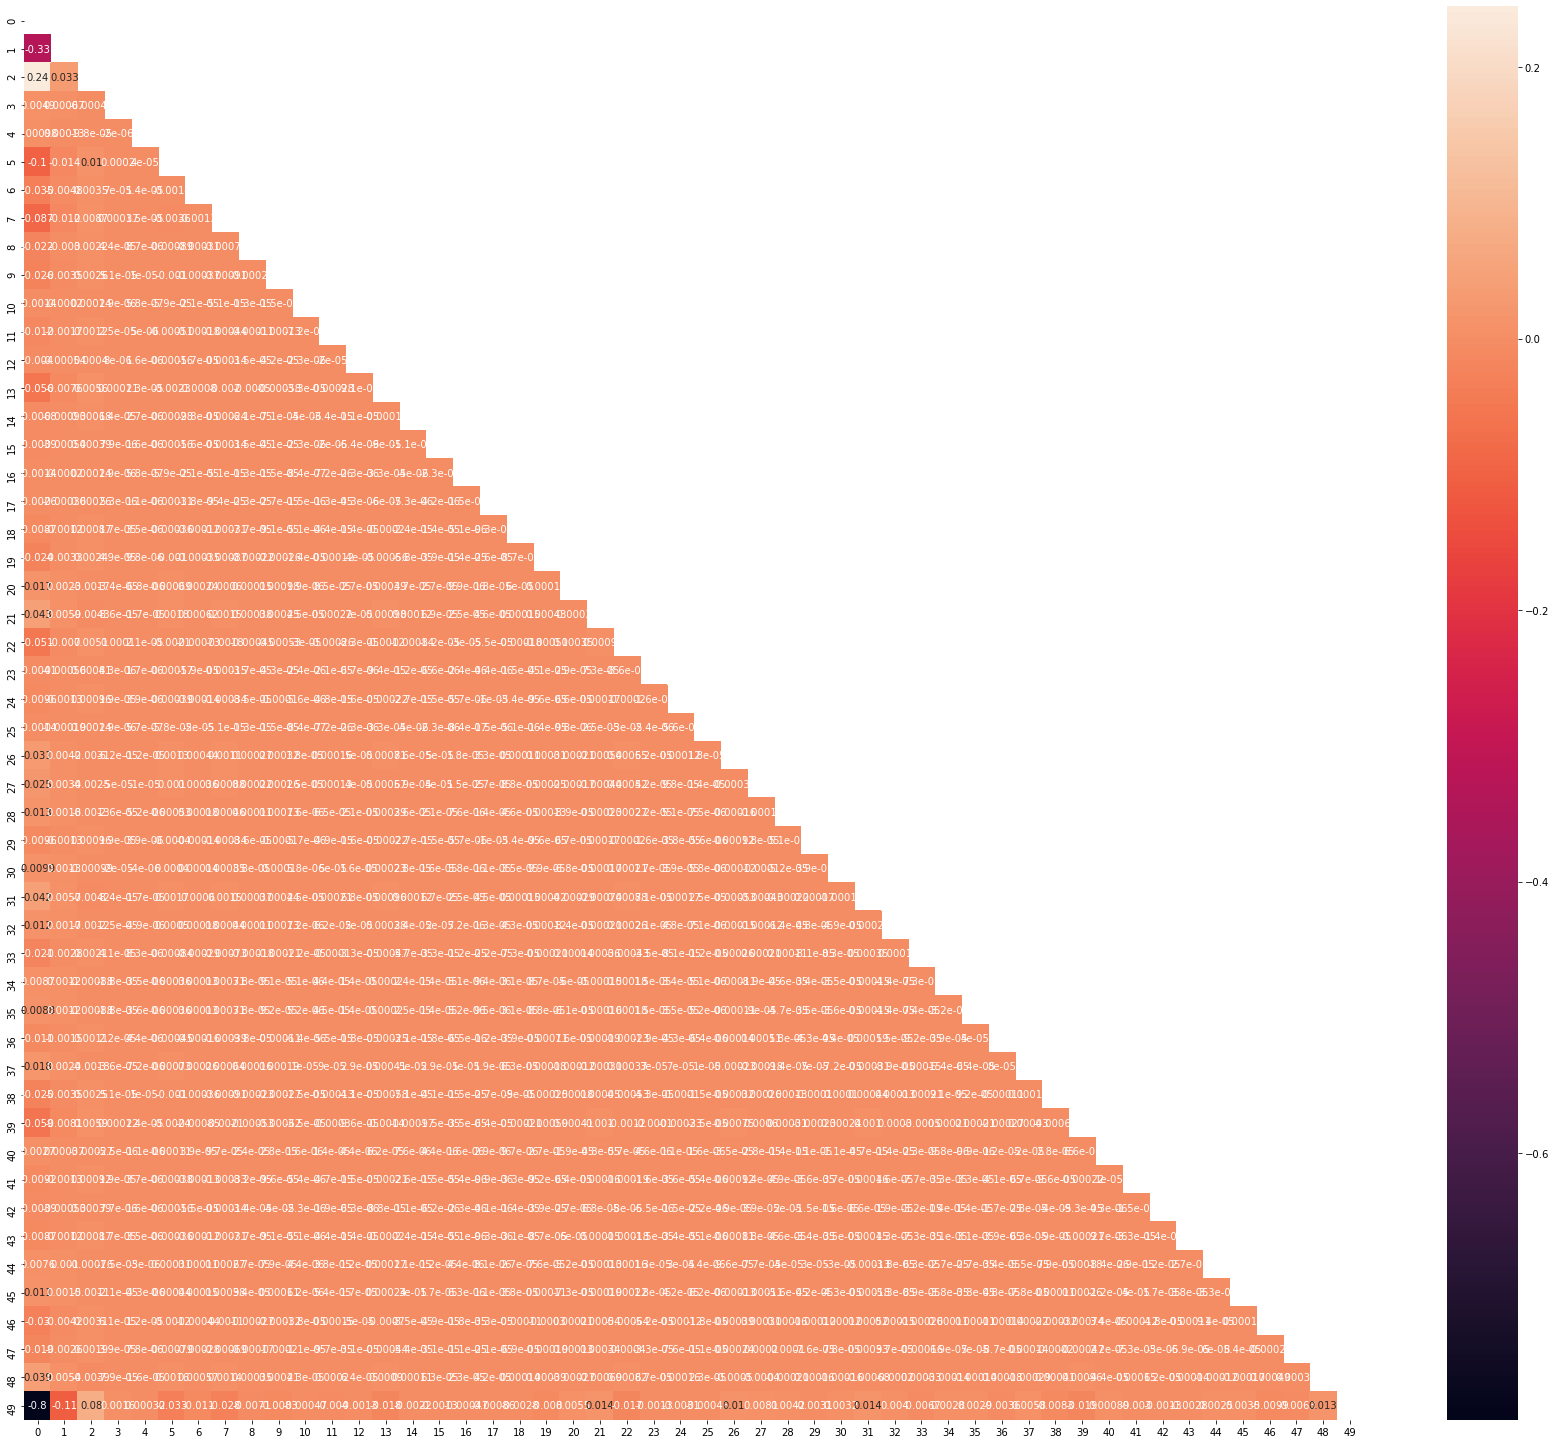

In [61]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

In [ ]:
X_embedded = tsne(pca_df,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


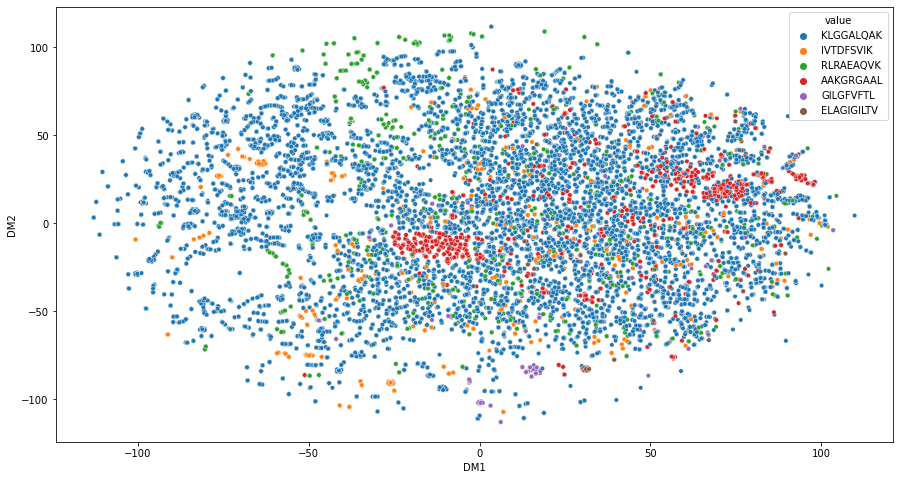

In [63]:

tsne_df_data = tsne_df.copy()
tsne_df_data['cdr3']=data_c_p.index
tsne_df_data=tsne_df_data.merge( data_c_n[['cdr3','value']], how='right', on='cdr3' )
tsne_df_data= tsne_df_data.groupby(['cdr3']).first().reset_index()
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['value'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='value',s=10)


### LogP without KLG

In [154]:
data_c_filter = data_c_all[data_c_all['value']!='KLGGALQAK']

In [155]:
data_c_n = norm_logp(data_c_filter, 'count')
data_c_p = pivot_data(data_c_n)

/home/yuliajk/.conda-envs/python3/bin/ipython:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [159]:
pca_df, pca_model = pca(data_c_p,46)
pca_df_data = pca_df.copy()
pca_df_data['cdr3']=data_c_p.index

pca_df_data=pca_df_data.merge(data_c_n[['cdr3']], how='right', on='cdr3' )
pca_df_data= pca_df_data.groupby(['cdr3']).first().reset_index()

<AxesSubplot:>

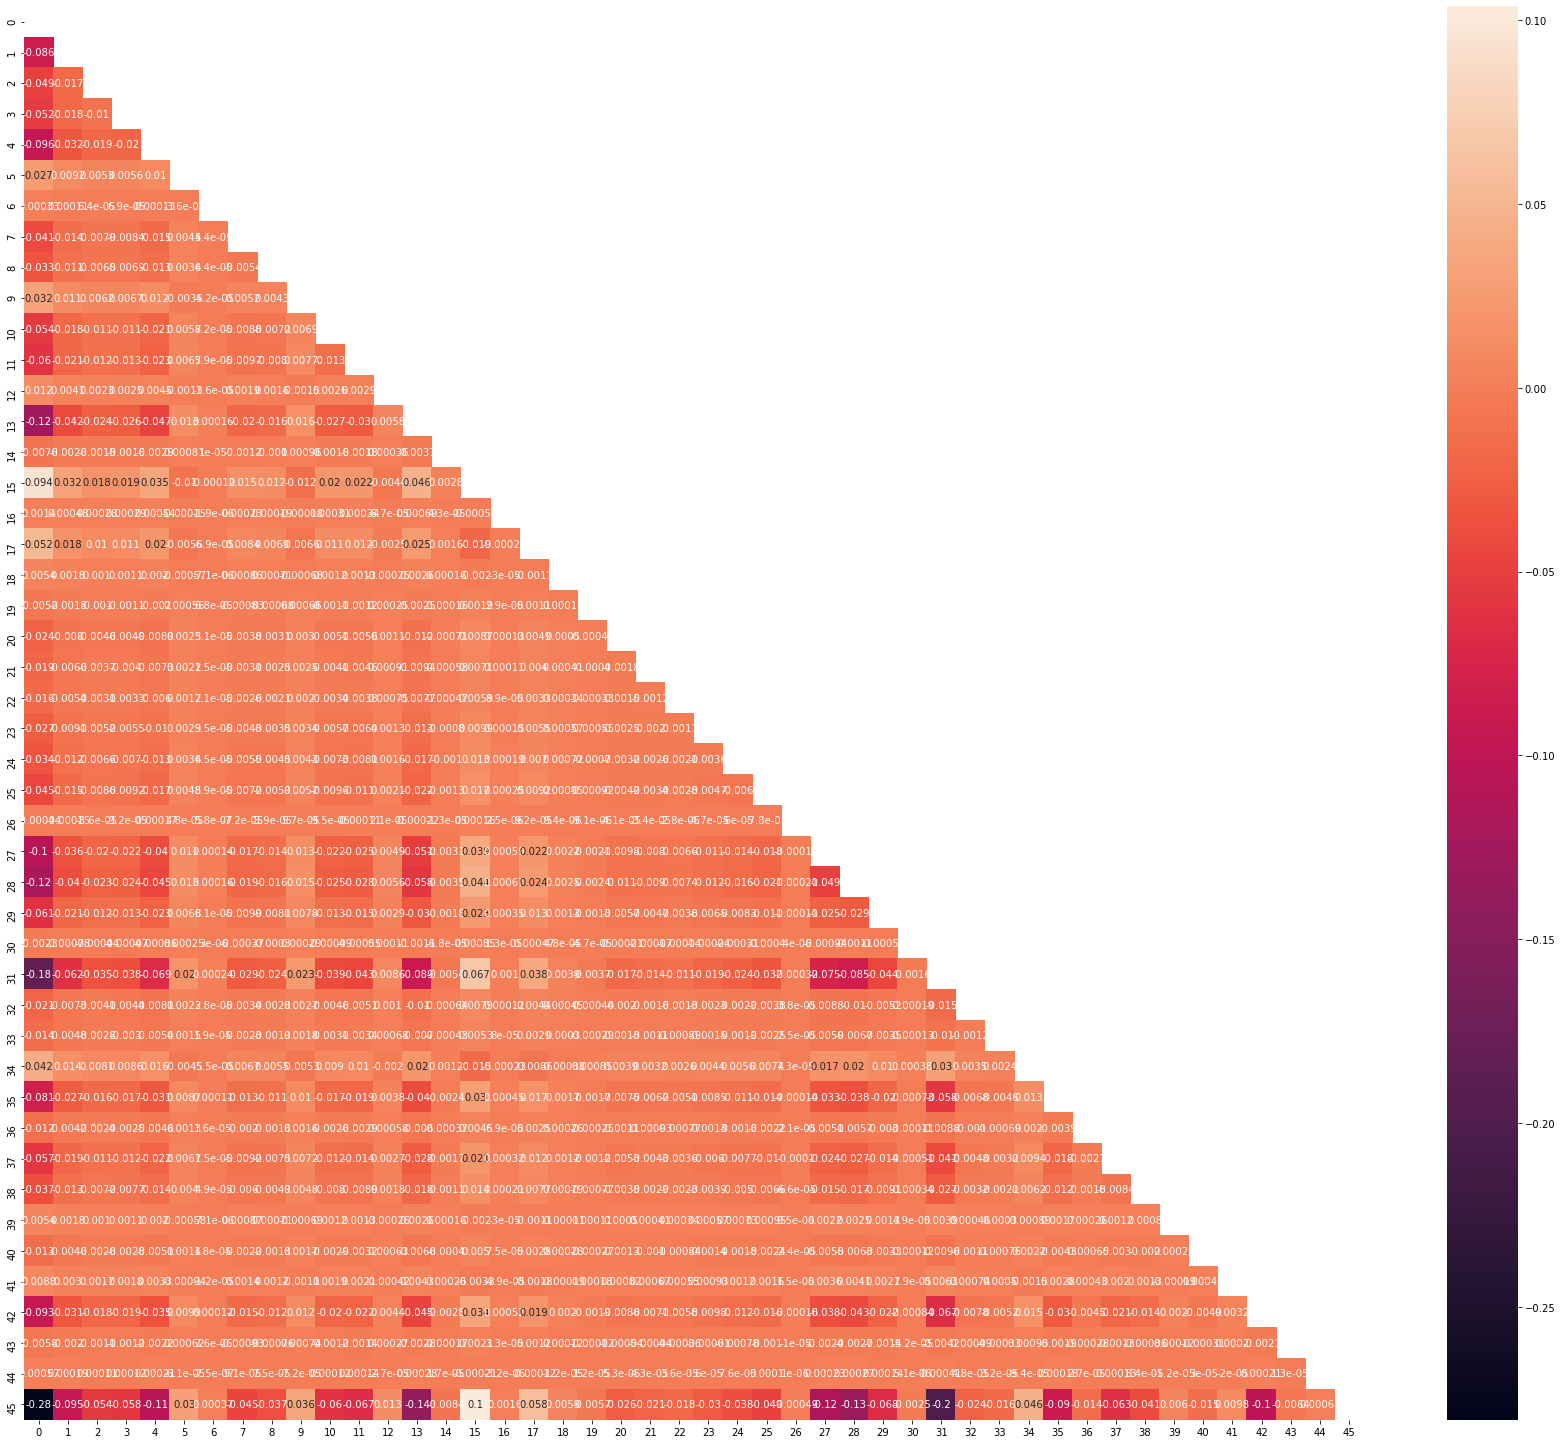

In [160]:
components_scores = pd.DataFrame(pca_model.components_.T)
corr_scores = components_scores.corr()

matrix = np.triu(corr_scores)
plt.figure(figsize=(30,26))
# using the upper triangle matrix as mask 
sns.heatmap(corr_scores, annot=True, mask=matrix)

In [ ]:
X_embedded = tsne(pca_df,2,0,5)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


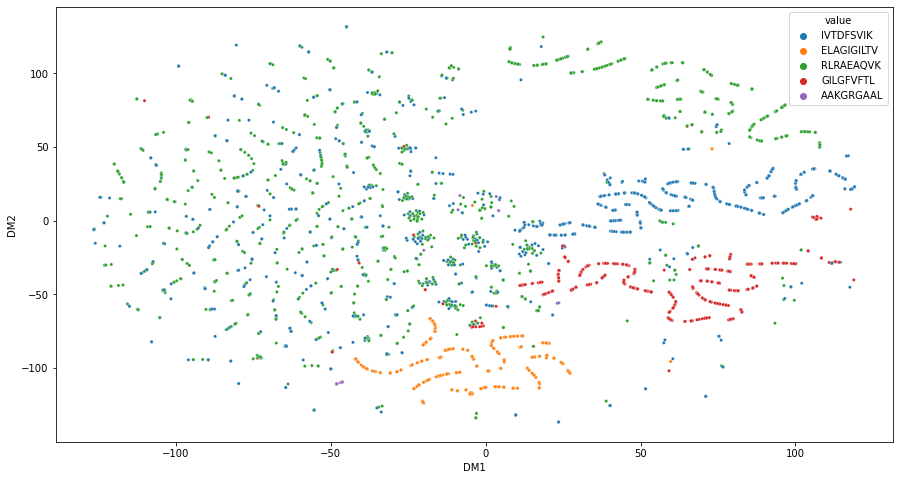

In [164]:

tsne_df_data = tsne_df.copy()
tsne_df_data['cdr3']=data_c_p.index
tsne_df_data=tsne_df_data.merge( data_c_n[['cdr3','value']], how='right', on='cdr3' )
tsne_df_data= tsne_df_data.groupby(['cdr3']).first().reset_index()
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['value'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='value',s=10)
